In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report


import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car_prices.csv


In [2]:
df = pd.read_csv("/kaggle/input/car_prices.csv", nrows=50000)

Selecting first 50k rows in order to get faster results.

In [3]:
df.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


Grasping some infos about the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          50000 non-null  int64  
 1   make          49765 non-null  object 
 2   model         49763 non-null  object 
 3   trim          49580 non-null  object 
 4   body          48332 non-null  object 
 5   transmission  43690 non-null  object 
 6   vin           50000 non-null  object 
 7   state         50000 non-null  object 
 8   condition     38208 non-null  float64
 9   odometer      49925 non-null  float64
 10  color         49860 non-null  object 
 11  interior      49860 non-null  object 
 12  seller        50000 non-null  object 
 13  mmr           50000 non-null  int64  
 14  sellingprice  50000 non-null  int64  
 15  saledate      50000 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 6.1+ MB


* year: Manufacturing year of the car.
* make: Car manufacturer.
* model: Model of the car.
* trim: Version or variant of the model.
* body: Body type (e.g., sedan, SUV).
* transmission: Type of transmission (e.g., automatic, manual).
* vin: Vehicle Identification Number (unique identifier for each car).
* state: Location where the car is sold.
* condition: Condition rating (from 1 to 50).
* odometer: Mileage of the car.
* color: Exterior color.
* interior: Interior color.
* seller: Name of the seller.
* mmr: Manheim Market Report value (estimated price).
* sellingprice: Actual selling price (target variable for prediction).
* saledate: Date of sale.

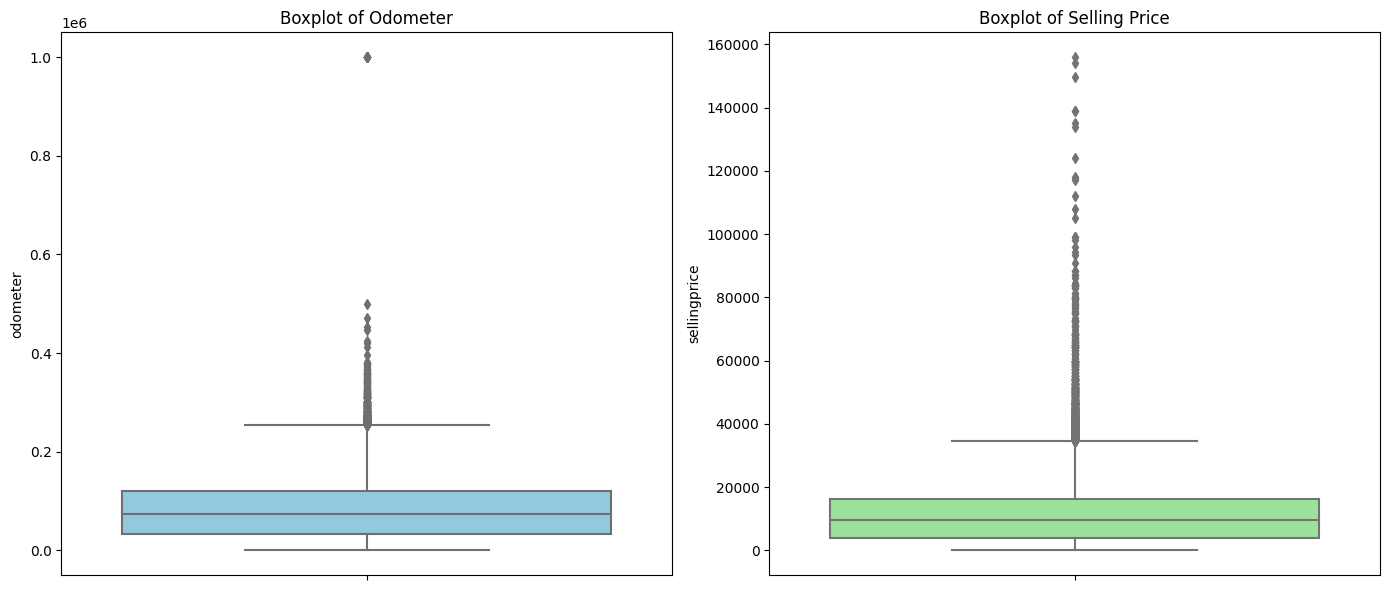

In [5]:
# 2. Visualizing outliers for 'odometer' and 'sellingprice'
plt.figure(figsize=(14, 6))

# Boxplot for 'odometer'
plt.subplot(1, 2, 1)
sns.boxplot(y=df['odometer'], color='skyblue')
plt.title('Boxplot of Odometer')

# Boxplot for 'sellingprice'
plt.subplot(1, 2, 2)
sns.boxplot(y=df['sellingprice'], color='lightgreen')
plt.title('Boxplot of Selling Price')

plt.tight_layout()
plt.show()

Viewing outliers.

In [6]:
# Remove outliers using IQR method for 'odometer' and 'sellingprice' with function
def remove_outlier(column):
    global df
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to remove outliers from 'sellingprice' and 'odometer'
remove_outlier('sellingprice')
remove_outlier('odometer')

Defining outlier remover function and using for odometer and sellingprice.

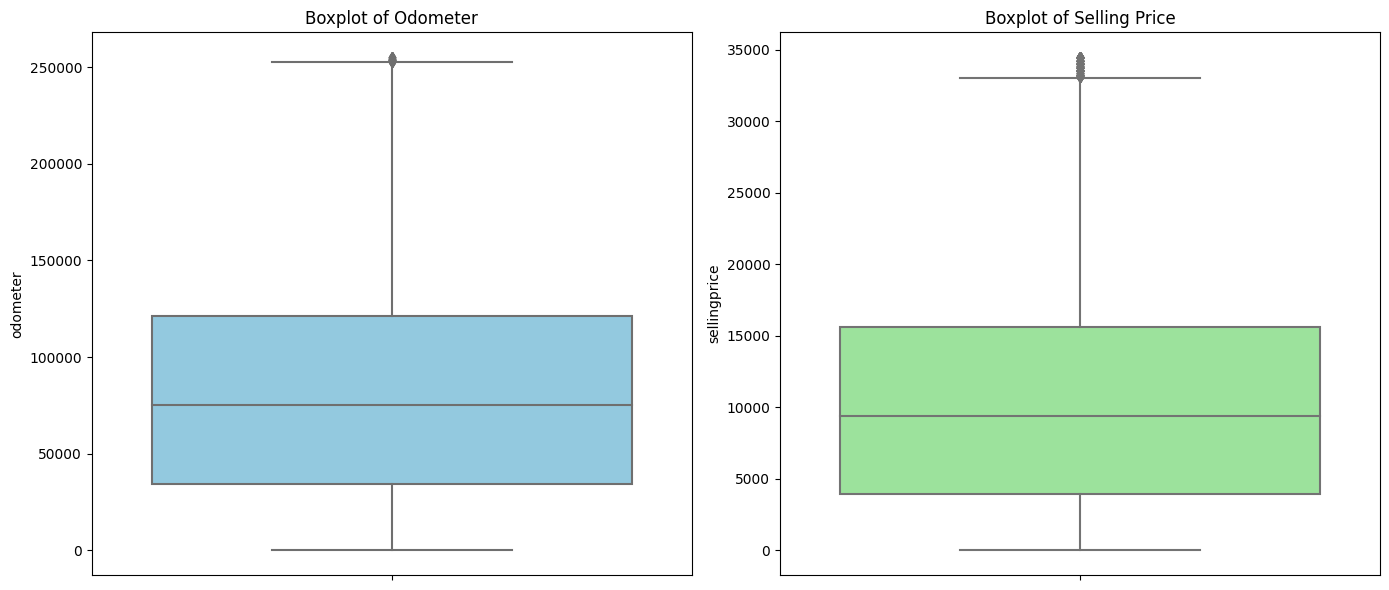

In [7]:
plt.figure(figsize=(14, 6))

# Boxplot for 'odometer'
plt.subplot(1, 2, 1)
sns.boxplot(y=df['odometer'], color='skyblue')
plt.title('Boxplot of Odometer')

# Boxplot for 'sellingprice'
plt.subplot(1, 2, 2)
sns.boxplot(y=df['sellingprice'], color='lightgreen')
plt.title('Boxplot of Selling Price')

plt.tight_layout()
plt.show()

Reviewing boxplot graph after outlier remove.

In [8]:
# Normalizing using MinMaxScaler
scaler = MinMaxScaler()
df['condition_normalized'] = scaler.fit_transform(df[['condition']])
df['odometer_normalized'] = scaler.fit_transform(df[['odometer']])
df['sellingprice_normalized'] = scaler.fit_transform(df[['sellingprice']])
df['year_normalized'] = scaler.fit_transform(df[['year']])

Normalizing numerical columns in order to prevent bias.

In [9]:
df = df.drop(columns=['make','body','vin','condition','saledate','seller', 'mmr','odometer','sellingprice','year'])

After Normalization, dropping unnecessary columns.

I have also deleted the 'mmr' column in order to reach more meaningful model. (Realistic).

In [10]:
df.describe()

,condition_normalized,odometer_normalized,sellingprice_normalized,year_normalized
count,36793.000000,48276.000000,48276.000000,48276.000000
mean,0.584789,0.323785,0.308797,0.783873
std,0.284572,0.218673,0.228084,0.147461
min,0.000000,0.000000,0.000000,0.000000
25%,0.416667,0.133949,0.114467,0.666667
50%,0.645833,0.295686,0.272443,0.800000
75%,0.791667,0.476123,0.452158,0.900000
max,1.000000,1.000000,1.000000,1.000000


Check if normalization worked.

In [11]:
df.head(5)

,model,trim,transmission,state,color,interior,condition_normalized,odometer_normalized,sellingprice_normalized,year_normalized
0,Sorento,LX,automatic,ca,white,black,0.083333,0.065196,0.623177,1.000000
1,Sorento,LX,automatic,ca,white,beige,0.083333,0.036803,0.623177,1.000000
2,3 Series,328i SULEV,automatic,ca,gray,black,0.916667,0.005212,0.869561,0.966667
3,S60,T5,automatic,ca,white,black,0.833333,0.055960,0.804342,1.000000
5,Altima,2.5 S,automatic,ca,gray,black,0.000000,0.021759,0.315922,1.000000


Review the dataset

In [12]:
df.isnull().sum()

model                        213
trim                         395
transmission                6048
state                          0
color                        122
interior                     122
condition_normalized       11483
odometer_normalized            0
sellingprice_normalized        0
year_normalized                0
dtype: int64

Checking the missing values.

In [13]:
# Fill missing values in each column with its mode (most frequent value)
df['model'].fillna(df['model'].mode()[0], inplace=True)
df['trim'].fillna(df['trim'].mode()[0], inplace=True)
df['transmission'].fillna(df['transmission'].mode()[0], inplace=True)
df['color'].fillna(df['color'].mode()[0], inplace=True)
df['interior'].fillna(df['interior'].mode()[0], inplace=True)
df['condition_normalized'].fillna(df['condition_normalized'].mode()[0], inplace=True)

Imputing the missing values with most frequent values of their column.

In [14]:
# Check if missing values are imputed
df.isnull().sum()

model                      0
trim                       0
transmission               0
state                      0
color                      0
interior                   0
condition_normalized       0
odometer_normalized        0
sellingprice_normalized    0
year_normalized            0
dtype: int64

Check if missing values are imputed.

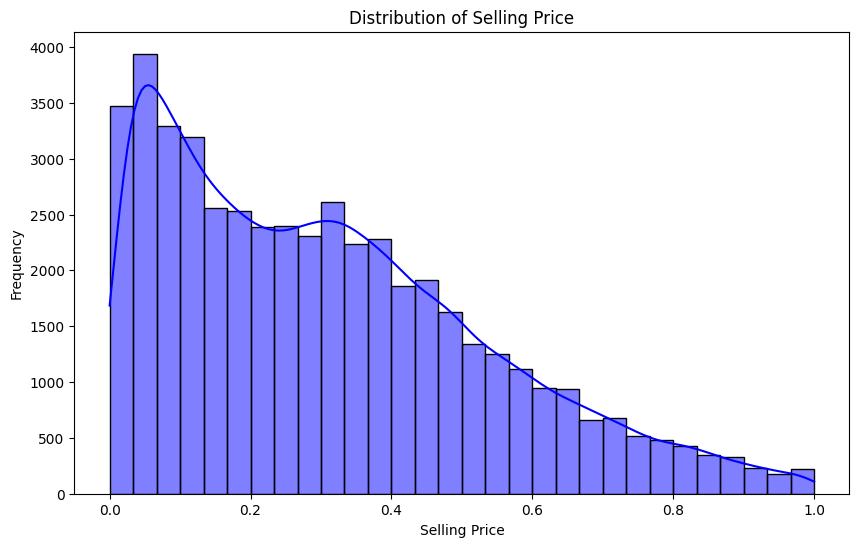

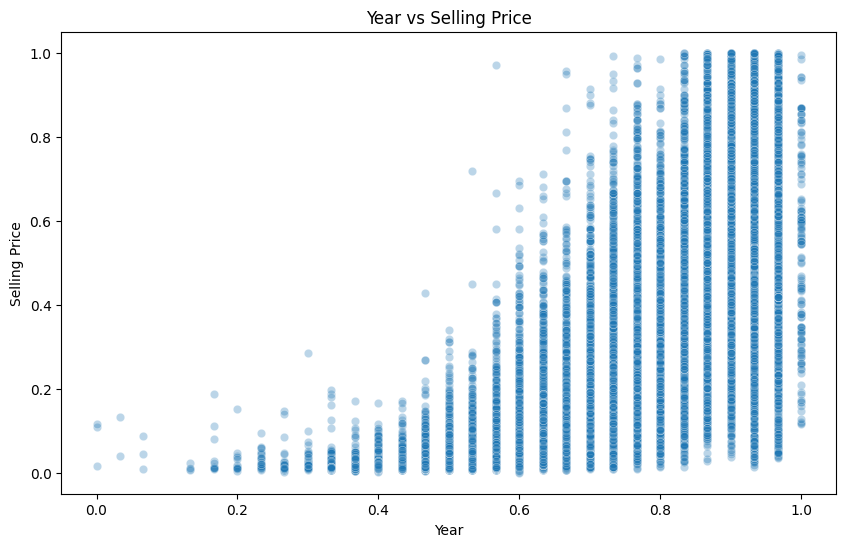

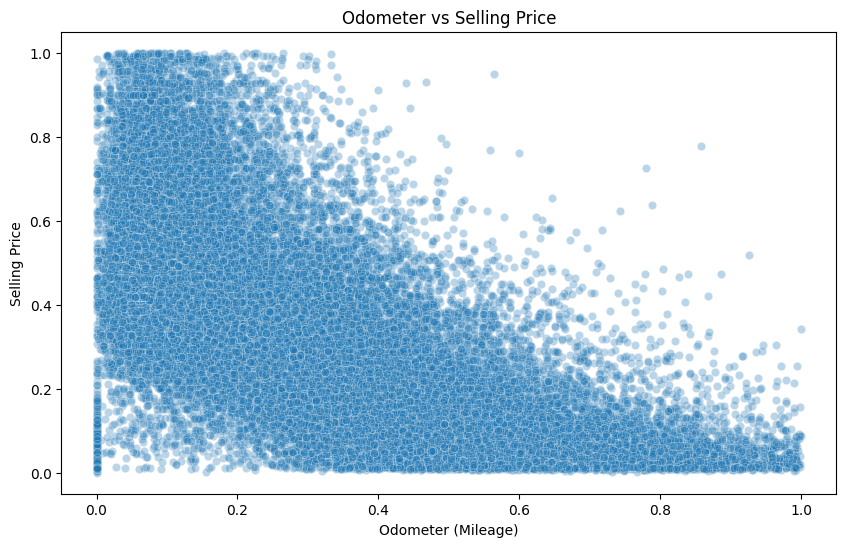

In [15]:
# 1. Distribution of Selling Price (Histogram)
plt.figure(figsize=(10, 6))
sns.histplot(df['sellingprice_normalized'], bins=30, kde=True, color='blue')
plt.title('Distribution of Selling Price')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

# 2. Year vs Selling Price (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year_normalized', y='sellingprice_normalized', data=df, alpha=0.3)
plt.title('Year vs Selling Price')
plt.xlabel('Year')
plt.ylabel('Selling Price')
plt.show()

# 3. Odometer vs Selling Price (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer_normalized', y='sellingprice_normalized', data=df, alpha=0.3)
plt.title('Odometer vs Selling Price')
plt.xlabel('Odometer (Mileage)')
plt.ylabel('Selling Price')
plt.show()

Displaying the dataset over graph in order to get insight about distribution.

In [16]:

# Separate categorical and numerical columns
categorical_cols = ['model', 'trim', 'transmission', 'color', 'interior']
numerical_cols = ['year_normalized', 'condition_normalized', 'odometer_normalized' , 'sellingprice_normalized']


In [17]:
# One-Hot Encoding for categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int)
encoded_categorical = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))

# Add feature names for encoded categories
encoded_categorical.columns = encoder.get_feature_names_out(categorical_cols)

Transforms categorical data into a format that machine learning models can easily understand and use.

In [18]:
# List of categorical columns to apply one-hot encoding
categorical_columns = ['model', 'trim', 'transmission', 'color', 'interior', 'state']

# Apply one-hot encoding using get_dummies
df_encoded = pd.get_dummies(df, dtype = int, columns=categorical_columns, drop_first=True)

# View the first few rows of the transformed dataframe
df_encoded.head()

,condition_normalized,odometer_normalized,sellingprice_normalized,year_normalized,model_1500,model_2 Series,model_200,model_200SX,model_2500,model_3,...,state_pa,state_pr,state_qc,state_sc,state_tn,state_tx,state_ut,state_va,state_wa,state_wi
0,0.083333,0.065196,0.623177,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.083333,0.036803,0.623177,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.916667,0.005212,0.869561,0.966667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.833333,0.055960,0.804342,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.000000,0.021759,0.315922,1.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check the encoded version of the dataset.

In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48276 entries, 0 to 49999
Columns: 2261 entries, condition_normalized to state_wi
dtypes: float64(4), int64(2257)
memory usage: 833.1 MB


In [20]:
# Define feature matrix (X) and target variable (y)
X = df_encoded.drop(columns=['sellingprice_normalized'])  # Features
y = df_encoded['sellingprice_normalized']  # Target

# Split the dataset into training and testing sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

%85 for train and %15 for test because it worked slightly well than 20-80. (%2-3)

In [21]:
# Train Random Forest to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

Gettin most important features to reduce column number. It will reduce runtime with minmum effect.

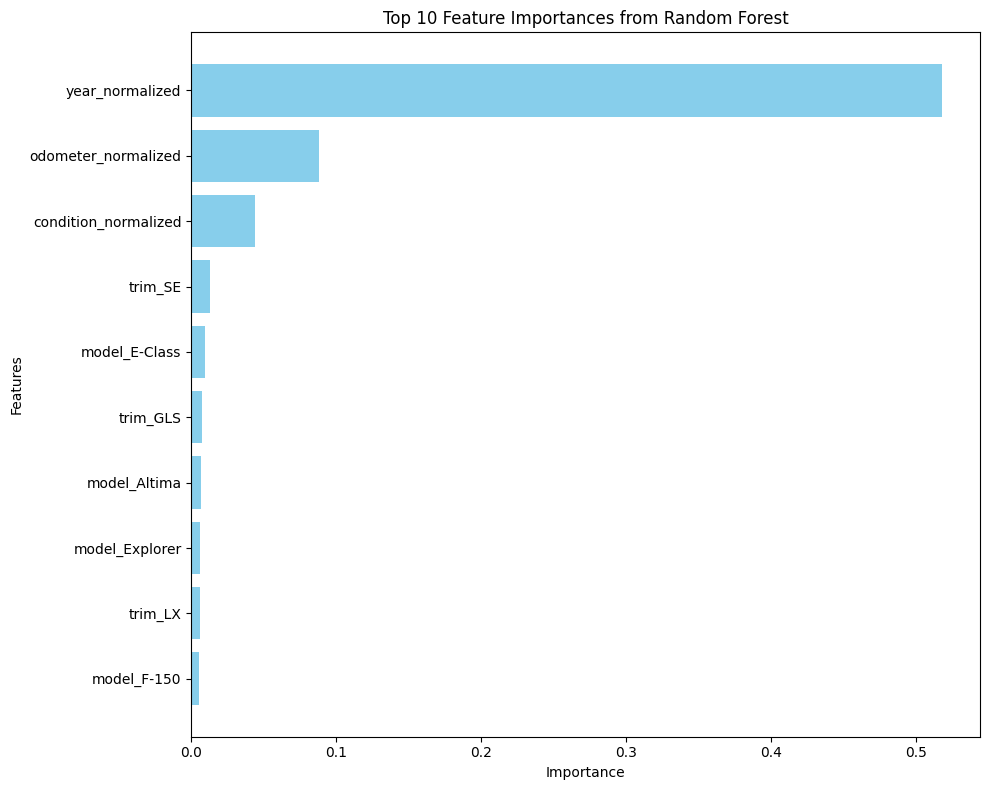

In [23]:
# Create a DataFrame with features and their importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select the top 250 features
top_250_features = feature_importances.head(250)['Feature'].values

top_10_importances = feature_importances.head(10)

# Plotting the top 10 feature importances
plt.figure(figsize=(10, 8))
plt.barh(top_10_importances['Feature'], top_10_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.tight_layout()
plt.show()

Visualising most important 10 features.

In [24]:
# Create new training and testing sets using only the top 250 features
X_train_top250 = X_train[top_250_features]
X_test_top250 = X_test[top_250_features]

# Train a new Random Forest model using only the top 250 features
rf_model_top250 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top250.fit(X_train_top250, y_train)

# Make predictions
y_pred_top250 = rf_model_top250.predict(X_test_top250)

In [25]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

rmse_top250 = mean_squared_error(y_test, y_pred_top250, squared=False)  # RMSE
r2_top250 = r2_score(y_test, y_pred_top250)  # R² Score

print(f"RMSE with Top 250 Features: {rmse_top250}")
print(f"R² Score with Top 250 Features: {r2_top250}")

RMSE with Top 250 Features: 0.08907454945391234
R² Score with Top 250 Features: 0.8459613137152528


Without Feature Selection and %80 train %20 test and with 10k rows:

Root Mean Squared Error (RMSE) - RF: 0.10885068840997505

R² Score - RF: 0.73814856752631

In [26]:
# Calculate Q1 and Q3
Q1 = df_encoded['sellingprice_normalized'].quantile(0.25)
Q3 = df_encoded['sellingprice_normalized'].quantile(0.75)

# Get min and max values for selling price
min_value = df_encoded['sellingprice_normalized'].min()
max_value = df_encoded['sellingprice_normalized'].max()

# Create a function to categorize prices into low, mid, high
def categorize_price(value):
    if value <= Q1:
        return 'low'
    elif Q1 < value <= Q3:
        return 'mid'
    else:
        return 'high'

# Apply the function to create the new categorical column
df_encoded['price_category'] = df_encoded['sellingprice_normalized'].apply(categorize_price)

# Check the distribution of the new price categories
print(df_encoded['price_category'].value_counts())


price_category
mid     24134
low     12079
high    12063
Name: count, dtype: int64


Categorizing 'sellingprice' with using IQR to predict with unsupervied models.

In [27]:

# Features and labels
X = df_encoded.drop(columns=['price_category'])
y = df_encoded['price_category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Train 70, test 30 (random)

In [28]:
# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [29]:
# Predict the categories on the test set
y_pred = model.predict(X_test)


In [30]:

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[3613    0    6]
 [   0 3573    6]
 [   0    0 7285]]

Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00      3619
         low       1.00      1.00      1.00      3579
         mid       1.00      1.00      1.00      7285

    accuracy                           1.00     14483
   macro avg       1.00      1.00      1.00     14483
weighted avg       1.00      1.00      1.00     14483



         odometer_normalized  year_normalized  condition_normalized  \
Cluster                                                               
0                   0.137142         0.908215              0.814932   
1                   0.586456         0.614404              0.343752   
2                   0.152274         0.890477              0.202931   
3                   0.348364         0.765339              0.551753   

         sellingprice_normalized  
Cluster                           
0                       0.528211  
1                       0.082833  
2                       0.440038  
3                       0.228374  


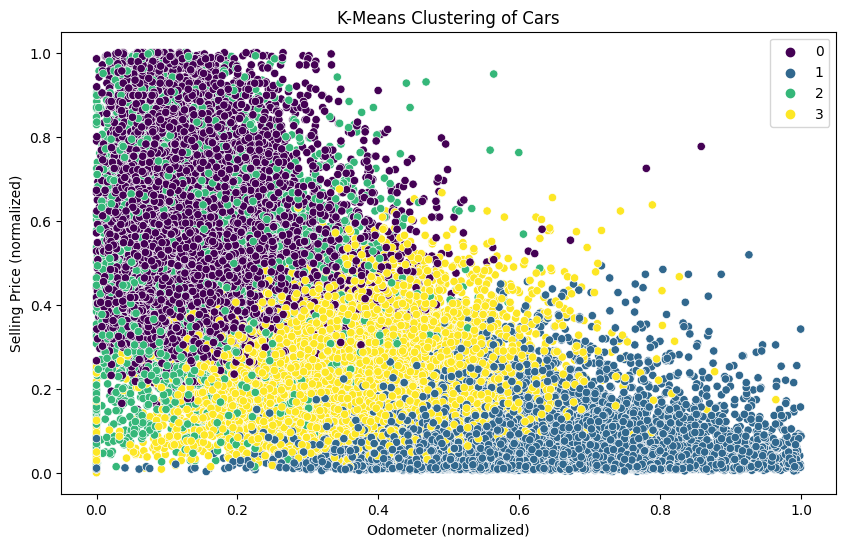

In [31]:

# Apply K-Means Clustering
# Define the number of clusters (random 4)
kmeans = KMeans(n_clusters=4, random_state=42)
selected_columns = ['odometer_normalized', 'year_normalized', 'condition_normalized', 'sellingprice_normalized']
df_new = df[selected_columns]
clusters = kmeans.fit_predict(df_new)  # Assuming df_encoded contains MinMaxScaled features

# Add the cluster labels to the dataframe
df_new['Cluster'] = clusters

# Analyze the clusters
cluster_analysis = df_new.groupby('Cluster').mean()
print(cluster_analysis)

# Visualize the clustering results using two important features, like 'odometer_normalized' and 'sellingprice_normalized'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_new['odometer_normalized'], y=df_new['sellingprice_normalized'], hue=clusters, palette='viridis')
plt.title('K-Means Clustering of Cars')
plt.xlabel('Odometer (normalized)')
plt.ylabel('Selling Price (normalized)')
plt.show()


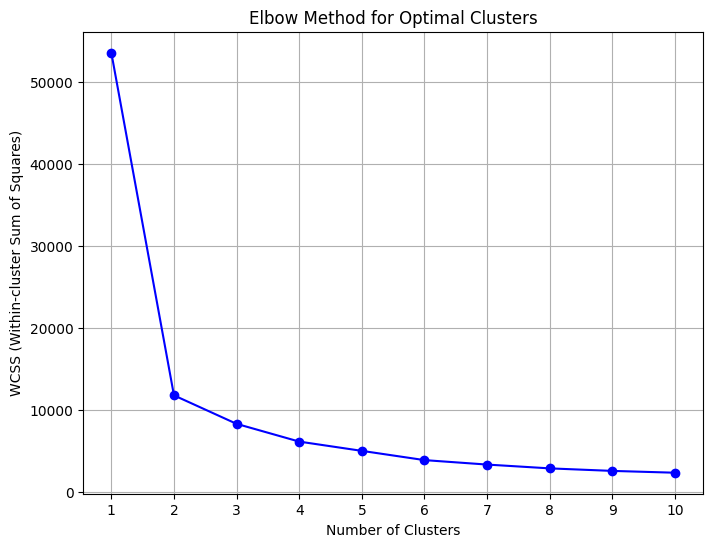

In [34]:
# Elbow Method
wcss = []
K = range(1, 11) # from 1 to 10
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_new)
    wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the closest cluster center

# Plot the Elbow Graph
plt.figure(figsize=(8, 6))
plt.plot(K, wcss, 'bo-', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')
plt.xticks(K)
plt.grid(True)
plt.show()


It shows that 4 clusters are optimum like we assumed.

Cluster counts:
DBSCAN_Cluster
 1    29732
-1    15758
 0     1803
 2      941
 3       42
Name: count, dtype: int64


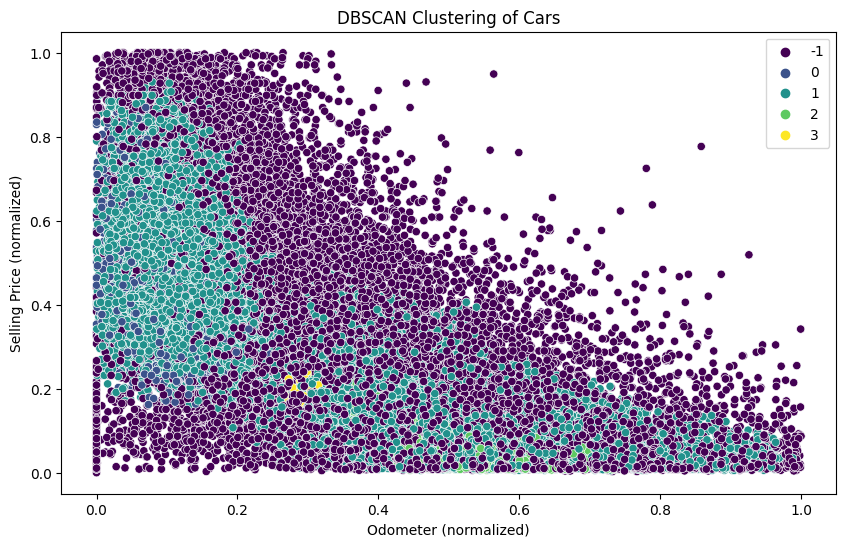

In [35]:
# Apply DBSCAN for practice
dbscan = DBSCAN(eps=0.05, min_samples=50)  # You can adjust eps and min_samples based on data exploration
selected_columns = ['odometer_normalized', 'year_normalized', 'condition_normalized', 'sellingprice_normalized']
df_new = df[selected_columns]
clusters = dbscan.fit_predict(df_new)

# Step 2: Add the cluster labels to the dataframe
df_new['DBSCAN_Cluster'] = clusters

# Step 3: Analyze the clusters
cluster_counts = df_new['DBSCAN_Cluster'].value_counts()
print(f"Cluster counts:\n{cluster_counts}")

# Step 4: Visualize the DBSCAN results using two features (odometer_normalized, sellingprice_normalized)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_new['odometer_normalized'], y=df_new['sellingprice_normalized'], hue=clusters, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Cars')
plt.xlabel('Odometer (normalized)')
plt.ylabel('Selling Price (normalized)')
plt.show()